In [1]:
from sympy.physics.quantum import TensorProduct as tp
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from numpy import linalg as la
import numpy as np
import time as tm

# Ising Model with transversal magnetic field!!!

$$H=−J\sum_{i=1}^L S_i^zS_{i+1}^z−h \sum_iS_i^x$$

In [2]:
class bin_operators:
    """It gives the states as binary and as number"""
    def __init__(self, chain):
        self.chain   = chain
        self.h_s = 2**chain #Hilbert size = h_s
        
    def binconf(self, state):
        """Entry with a state as number and return a state as binary(type string). 
        
           Ex: input = 44 | output = '0101100'. 
        """
        if state < self.h_s:
            binary = np.binary_repr(state , self.chain)
            return binary
        else:
            print("for this chain the max state is {} which represent".format(self.h_s-1))
            np.binary_repr(self.h_s-1,self.chain)
            return np.binary_repr(self.h_s-1,self.chain)
    
    def state(self,binconf):
        """If we have the binary and need the state as number, what is between 0 and 2^chain-1. """
        return int(binconf,2) 
        
    def readsite(self,state, i):
        """Enter with a int and return 0 or 1 in a position i as integer
        
           Ex: input = state = 7, i=0 | '111' | output = return 0.
        """
        conf = self.binconf(state)
        return int(conf[i])
    
    def all_states(self):
        """If you need to see the states as binary. Return a list"""
        return [np.binary_repr(i,self.chain) for i in range(self.h_s)]
p = bin_operators(2)
print(p.all_states())

['00', '01', '10', '11']


## Setting the basis!

$$
\sigma_z=\begin{pmatrix}
1&0\\
0&-1\\
\end{pmatrix},
\sigma_x=\begin{pmatrix}
0&1\\
1&0\\
\end{pmatrix},
\sigma_y=\begin{pmatrix}
0&-i\\
i&0\\
\end{pmatrix}
$$
$$
|0\rangle=\begin{pmatrix}
0\\
1\\
\end{pmatrix},
|1\rangle=\begin{pmatrix}
1\\
0\\
\end{pmatrix}
$$


$$
\begin{pmatrix}
1&0\\
0&-1\\
\end{pmatrix}
\begin{pmatrix}
0\\
1\\
\end{pmatrix}
=
-\begin{pmatrix}
0\\
1\\
\end{pmatrix}
\longrightarrow
\sigma_z|0\rangle=-|0\rangle
$$
$$
\begin{pmatrix}
1&0\\
0&-1\\
\end{pmatrix}
\begin{pmatrix}
1\\
0\\
\end{pmatrix}
=+
\begin{pmatrix}
1\\
0\\
\end{pmatrix}
\longrightarrow
\sigma_z|1\rangle=+|1\rangle
$$


$$\begin{pmatrix}
0&1\\
1&0\\
\end{pmatrix}
\begin{pmatrix}
0\\
1\\
\end{pmatrix}=+
\begin{pmatrix}
1\\
0\\
\end{pmatrix}
\longrightarrow
\sigma_x|0\rangle=+|1\rangle
$$

$$\begin{pmatrix}
0&1\\
1&0\\
\end{pmatrix}
\begin{pmatrix}
1\\
0\\
\end{pmatrix}=+
\begin{pmatrix}
0\\
1\\
\end{pmatrix}
\longrightarrow
\sigma_x|1\rangle=+|0\rangle
$$

$$\begin{pmatrix}
0&-i\\
i&0\\
\end{pmatrix}
\begin{pmatrix}
0\\
1\\
\end{pmatrix}=-i
\begin{pmatrix}
1\\
0\\
\end{pmatrix}
\longrightarrow
\sigma_y|0\rangle=-i|1\rangle
$$

$$\begin{pmatrix}
0&-i\\
i&0\\
\end{pmatrix}
\begin{pmatrix}
1\\
0\\
\end{pmatrix}=+i
\begin{pmatrix}
0\\
1\\
\end{pmatrix}
\longrightarrow
\sigma_y|1\rangle=+i|0\rangle
$$

In [4]:
#Arrumar SxSx e SySy
class spin_operators:
    def __init__(self,chain):
        """This class gives the operation of spins productor between spins in same ket(state)
        
           We need to use the bin operators = bo
        
           binconf   (state=number          )
           state     (binconf=binary        )
           readsite  (state=number, i=number)
           all_states(                      )
        """
        self.chain = chain
        self.bo = bin_operators(chain)
        self.hs= bin_operators(chain).h_s
        
    def Sx(self, state,i):
        """This method apply 1/2sigma_x in the spin's site i. 
        
           Ex: s1|001>=1/2|101>
        """
        site = np.arange(self.chain-1,-1,-1)
        try:
            return 1/2, state^(1<<(site[i]))
        except:
            print('wrong answer! It was applied sx1. The max i is: {}'.format(self.chain-1))
            return 1/2, state^(1<<(site[0]))
    
    def Sy(self, state,i):
        """This method apply 1/2sigma_y in the spin's site i. 
        
           Ex: s1|001>=-1/2j|101> or s3|001>=1/2j|101>
        """
        site = np.arange(self.chain-1,-1,-1)
        try:
            if state^(1<<(site[i])) == 1:
                return  -1j/2, state^(1<<(site[i]))
            else: return 1j/2, state^(1<<(site[i]))
    
        except:
            print('wrong answer! It was applied sy1. The max i is: {}'.format(self.chain-1))
            return 1j/2, state^(1<<(site[0]))
        
    def Sz(self, state ,i ):
        """Si|0101010001> = si|0101010001> where si is a number 
        
           ex: S1|01> = -1/2|01> or S2|01> = 1/2|01>
        """
        si = self.bo.readsite(state, i)-1/2
        return si,state
    
    def SxSx(self,state,i):
        """SiSj|010101> = sisj|010101> where si and sj is a number 
        
           ex:S1S2|01> = 1/2 1/2|10>
        """
        site = np.arange(self.chain-1,-1,-1)
        if site[i]==0:
            return 1/4, state^(1<<site[i])^(1<<(self.chain-1))
        else:
            return 1/4, state^(1<<site[i])^(1<<(site[i]-1))
        
    def SySy(self,state,i):
        """SiSj|010101> = sisj|010101> where si and sj is a number 
        
           ex:S1S2|01> = -1j/2 1j/2 |10> = 1/4 |10>
        """
        j   = self.bo.readsite(state,i)
        jp1 = self.bo.readsite(state,(i+1)%self.chain)
        if j+jp1 == 0 or j+jp1 ==2:
            ev = -1/4
        else: ev =1/4
        
        site = np.arange(self.chain-1,-1,-1)
        if site[i]==0:
            return ev, state^(1<<site[i])^(1<<(self.chain-1))
        else:
            return ev, state^(1<<site[i])^(1<<(site[(i+1)%(self.chain)]))
    
    def SzSz(self, state ,i):
        """SiSj|0101010001> = sisj|0101010001> where si and sj is a number
        
           ex:S1S2|01> = -1/2 1/2|01>
        """
        si = self.bo.readsite(state, i%self.chain)-1/2
        sj = self.bo.readsite(state, (i+1)%self.chain)-1/2
        return si*sj
print(p.all_states())
spin_operators(2).SySy(3,1)

['00', '01', '10', '11']


(-0.25, 0)

In [19]:
class Ising_model:
    def __init__(self, chain):
        """You need to call spin operator = self.so.(plus)
        
           plus:
           Sx  (state,i  )
           Sy  (state,i  )
           Sz  (state,i  )    
           SxSx(state,i  )
           SySy(state,i  )
           SzSz(state,i,j)
        """
        self.chain = chain
        self.hs    = 2**chain
        self.so    = spin_operators(chain)
    
    def Hamiltonian_int(self):
        """Ising Hamiltonia with boundary conditions S_N = S_0 only for SzSz"""
        egv_bc= [sum([self.so.SzSz(k,i) for i in range(self.chain)]) for k in range(self.hs)]       
        return egv_bc
    
    def Hamiltonian(self,J,h):
        H = -J*np.diag( self.Hamiltonian_int() )
        for state in range(self.hs):
            for j in range(self.chain):
                value, newstate = self.so.Sx(state,j)
                H[newstate,state] -= h*value
        return H
    
    def eg_ValVec(self,J,h):
        egval, egvec=la.eigh(self.Hamiltonian(J,h))
        return egval, egvec**2
    
    def plot(self,J,h,i=0):
        ini = tm.time()
        EVev = self.eg_ValVec(J,h)[1]
        plt.plot(EVev[:,i],'red')
        plt.plot(EVev[i,:],'k')
        plt.show()
        end = tm.time()
        print("time: {} second".format(end-ini))
        return
        
Ising_model(3).Hamiltonian(1,1)

array([[-0.75, -0.5 , -0.5 , -0.  , -0.5 , -0.  , -0.  , -0.  ],
       [-0.5 ,  0.25, -0.  , -0.5 , -0.  , -0.5 , -0.  , -0.  ],
       [-0.5 , -0.  ,  0.25, -0.5 , -0.  , -0.  , -0.5 , -0.  ],
       [-0.  , -0.5 , -0.5 ,  0.25, -0.  , -0.  , -0.  , -0.5 ],
       [-0.5 , -0.  , -0.  , -0.  ,  0.25, -0.5 , -0.5 , -0.  ],
       [-0.  , -0.5 , -0.  , -0.  , -0.5 ,  0.25, -0.  , -0.5 ],
       [-0.  , -0.  , -0.5 , -0.  , -0.5 , -0.  ,  0.25, -0.5 ],
       [-0.  , -0.  , -0.  , -0.5 , -0.  , -0.5 , -0.5 , -0.75]])

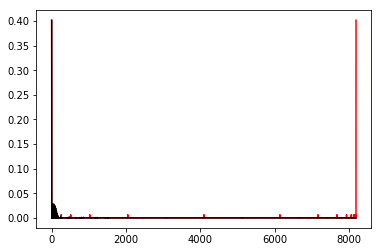

time: 76.2632315158844 second


In [25]:
Ising_model(13).plot(2,0.5)


The Bitwise Operators:

$x << y$

    Returns x with the bits shifted to the left by y places (and new bits on the right-hand-side are zeros). This is the same as multiplying x by 2**y. 

$x >> y$

    Returns x with the bits shifted to the right by y places. This is the same as //'ing x by 2**y. 

$x & y$

    Does a "bitwise and". Each bit of the output is 1 if the corresponding bit of x AND of y is 1, otherwise it's 0. 

$x | y$

    Does a "bitwise or". Each bit of the output is 0 if the corresponding bit of x AND of y is 0, otherwise it's 1.
    
$~ x$

    Returns the complement of x - the number you get by switching each 1 for a 0 and each 0 for a 1. This is the same as -x - 1. 

$x ^ y$

    Does a "bitwise exclusive or". Each bit of the output is the same as the corresponding bit in x if that bit in y is 0, and it's the complement of the bit in x if that bit in y is 1. 

Just remember about that infinite series of 1 bits in a negative number, and these should all make sense.